# Optimizing Profits in Real Estate

**Research Question:** Can you predict favorable times to sell a house where the current state of the housing market will enable a faster sale for closer to asking price?

**Dataset:** I'll explore weekly measurements of housing market metrics collected by Redfin. The data were downloaded from [this source](https://www.redfin.com/blog/data-center/). Each row in this dataset characterizes what I will call the "state of the housing market" at a certain point in time.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

/Users/rmorgan/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
redfin = pd.read_csv('weekly_housing_market_data_most_recent.csv000')

In [3]:
# Select rows corresponding to the shortest-duration measurment (1 week)
redfin_weeks = redfin[redfin['duration'].values == '7 days'].copy().reset_index(drop=True)

Naively, we might characterize a housing-market state that is favorable to fast-selling homes by the `percent_off_market_in_two_weeks` column in this dataset.

In [4]:
# Choose the top 5% of housing-market states for the fast-selling homes
cutoff = np.percentile(redfin_weeks['percent_off_market_in_two_weeks'].values, q=95)

In [5]:
fast_selling_homes = redfin_weeks[redfin_weeks['percent_off_market_in_two_weeks'].values > cutoff].copy().reset_index(drop=True)
slow_selling_homes = redfin_weeks[redfin_weeks['percent_off_market_in_two_weeks'].values < cutoff].copy().reset_index(drop=True)

## Motivation

In real-estate, agents make a larger profit if they are able to sell properties quickly and close to asking price. The longer a property remains on the market, the more likely a seller will be to reduce the price, leading to missed revenue.

This pattern is present in the selected Redfin dataset.

In [6]:
price_drops = redfin_weeks['average_price_drop_ratio'].values[~np.isnan(redfin_weeks['average_price_drop_ratio'].values)]
price_drop_bins = np.linspace(price_drops.min(), price_drops.max(), 25)
fast_counts, fast_edges = np.histogram(fast_selling_homes['average_price_drop_ratio'].values, bins=price_drop_bins, density=True)
slow_counts, slow_edges = np.histogram(slow_selling_homes['average_price_drop_ratio'].values, bins=price_drop_bins, density=True)
centers = [0.5 * (price_drop_bins[i] + price_drop_bins[i+1]) for i in range(len(price_drop_bins) -1)]

## Asset 1

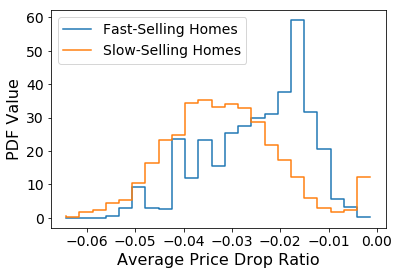

In [7]:
plt.figure()
plt.step(centers, fast_counts, label='Fast-Selling Homes')
plt.step(centers, slow_counts, label='Slow-Selling Homes')
plt.xlabel("Average Price Drop Ratio", fontsize=16)
plt.ylabel("PDF Value", fontsize=16)
plt.legend(loc='upper left', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

When a higher fraction of homes in an area sell withing two weeks of being put on the market, they sell on average closer to the initial asking price than homes in an area with lower fractions of homes selling within two weeks of being put on the market.

Therefore, if the times at which homes are more likely to sell quickly can be identified, real-estate agents can increase revenvue by listing properties during those times. In the remainder of this notebook, I will demonstrate that these "favorable housing-market states" can be identified by basing an inference off of measurments in the Redfin dataset.

As a test-case, I will limit my focus to Seattle.

## Determining Favorable Seattle Housing Market States

In [8]:
seattle_fast = fast_selling_homes[fast_selling_homes['region_name'].values == 'Seattle'].copy().reset_index(drop=True)
seattle_slow = slow_selling_homes[slow_selling_homes['region_name'].values == 'Seattle'].copy().reset_index(drop=True)

In [9]:
# convert dates to year, month, and day columns to illuminate seasonal trends
seattle_fast['year'] = [int(x.split('-')[0]) for x in seattle_fast['period_begin'].values]
seattle_fast['month'] = [int(x.split('-')[1]) for x in seattle_fast['period_begin'].values]
seattle_fast['day'] = [int(x.split('-')[2]) for x in seattle_fast['period_begin'].values]
seattle_slow['year'] = [int(x.split('-')[0]) for x in seattle_slow['period_begin'].values]
seattle_slow['month'] = [int(x.split('-')[1]) for x in seattle_slow['period_begin'].values]
seattle_slow['day'] = [int(x.split('-')[2]) for x in seattle_slow['period_begin'].values]

Remove data columns if they will not benefit the analysis. The reason for each feature's removal ia listed in the comments below.

In [10]:
bad_features = [
# Uninformative
'last_updated',
# Redundent based on selection of wee-long periods in Seattle
'duration',
'region_id',
'region_type_id',
'region_name',
'region_type',
# Redundent based on fixed duration and utilization of 'year', 'month', and 'day'
'period_begin',
'period_end',
# Perhaps too close to the qualities we're interested in predicting
# i.e., the inclusion of these features will produce overly-optimistic results
'median_days_to_close',
'median_days_to_close_yoy',
'off_market_in_two_weeks',
'off_market_in_two_weeks_yoy',
'percent_off_market_in_two_weeks',
'percent_off_market_in_two_weeks_yoy',
'homes_delisted',
'homes_delisted_yoy',
'percent_active_listings_delisted',
'percent_active_listings_delisted_yoy',
#contains many NaN values, it is likely more interesting to look at real-time
#trends as opposed to year-over-year trends
'total_homes_sold_yoy',
'total_homes_sold_with_price_drops_yoy',
'percent_total_homes_sold_with_price_drops_yoy',
'median_sale_price_yoy',
'median_sale_ppsf_yoy',
'price_drops_yoy',
'percent_of_total_active_listings_with_price_drops_yoy',
'percent_of_median_active_listings_with_price_drops_yoy',
'pending_sales_yoy',
'total_new_listings_yoy',
'median_new_listing_price_yoy',
'median_new_listing_ppsf_yoy',
'inventory_yoy',
'total_active_listings_yoy',
'median_active_listings_yoy',
'median_listing_with_price_drops_yoy',
'average_price_drop_ratio_yoy',
'age_of_inventory_yoy',
'median_active_list_price_yoy',
'median_active_list_ppsf_yoy',
'average_of_median_list_price_amount_yoy',
'average_of_median_offer_price_amount_yoy',
'avg_offer_to_list_yoy']

In [11]:
good_features = [x for x in seattle_fast.columns if x not in bad_features]
print(good_features)

['total_homes_sold', 'total_homes_sold_with_price_drops', 'percent_total_homes_sold_with_price_drops', 'median_sale_price', 'median_sale_ppsf', 'price_drops', 'percent_of_total_active_listings_with_price_drops', 'percent_of_median_active_listings_with_price_drops', 'pending_sales', 'total_new_listings', 'median_new_listing_price', 'median_new_listing_ppsf', 'inventory', 'total_active_listings', 'median_active_listings', 'median_listing_with_price_drops', 'average_price_drop_ratio', 'age_of_inventory', 'median_active_list_price', 'median_active_list_ppsf', 'average_of_median_list_price_amount', 'average_of_median_offer_price_amount', 'avg_offer_to_list', 'year', 'month', 'day']


In [12]:
# Select training and testing sets
seattle_fast['TRUTH'] = 'Fast'
seattle_slow['TRUTH'] = 'Slow'
data_df = pd.concat([seattle_fast, seattle_slow]).dropna()

#dropping rows with NaNs removes very few rows and will not hinder the overall results

X = data_df[good_features].values
y = data_df['TRUTH'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=6)

Train a RandomForestClassifier to find the most important features that can classify fast-selling versus slow-selling housing market states.

In [13]:
rfc = RandomForestClassifier(n_estimators=50, n_jobs=-1)
rfc.fit(X_train, y_train)
y_train_pred = rfc.predict(X_train)
y_test_pred = rfc.predict(X_test)

In [14]:
print(accuracy_score(y_train_pred, y_train))
print(accuracy_score(y_test_pred, y_test))

1.0
0.9648562300319489


The classifier seems to have predictive power, but is overfitting the training data. We can quickly tune it to avoid overfitting.

In [15]:
training_accuracy, testing_accuracy = [], []

max_depth_list = [2, 3, 4, 5, 6, 7, 8, 9, 10]
for max_depth in max_depth_list:
    rfc = RandomForestClassifier(n_estimators=50, n_jobs=-1, max_depth=max_depth)
    rfc.fit(X_train, y_train)
    y_train_pred = rfc.predict(X_train)
    y_test_pred = rfc.predict(X_test)
    
    training_accuracy.append(accuracy_score(y_train_pred, y_train))
    testing_accuracy.append(accuracy_score(y_test_pred, y_test))

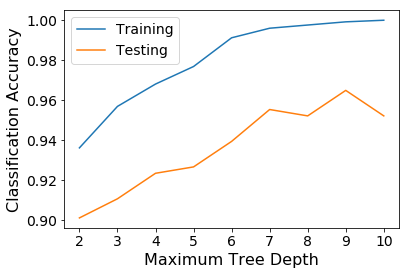

In [16]:
plt.figure()
plt.plot(max_depth_list, training_accuracy, label='Training')
plt.plot(max_depth_list, testing_accuracy, label='Testing')
plt.xlabel("Maximum Tree Depth", fontsize=16)
plt.ylabel("Classification Accuracy", fontsize=16)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

Select `max_depth=9` based on performancs on testing data.

In [17]:
training_accuracy, testing_accuracy = [], []

estimator_list = [1, 2, 5, 10, 20, 50, 100]
for n_estimators in estimator_list:
    rfc = RandomForestClassifier(n_estimators=n_estimators, n_jobs=-1, max_depth=9)
    rfc.fit(X_train, y_train)
    y_train_pred = rfc.predict(X_train)
    y_test_pred = rfc.predict(X_test)
    
    training_accuracy.append(accuracy_score(y_train_pred, y_train))
    testing_accuracy.append(accuracy_score(y_test_pred, y_test))
    

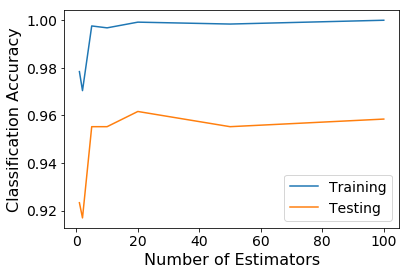

In [18]:
plt.figure()
plt.plot(estimator_list, training_accuracy, label='Training')
plt.plot(estimator_list, testing_accuracy, label='Testing')
plt.xlabel("Number of Estimators", fontsize=16)
plt.ylabel("Classification Accuracy", fontsize=16)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

Select `n_estimators=20` based on performance on testing data.

Train a RandomForestClassifier with the optimal hyperparameters.

In [19]:
rfc = RandomForestClassifier(n_estimators=20, n_jobs=-1, max_depth=9)
rfc.fit(X_train, y_train)
y_test_pred = rfc.predict(X_test)
final_accuracy = accuracy_score(y_test_pred, y_test)

Analyze feature importances determined by the RandomForestClassifier

In [20]:
feature_data = [[good_features[i], rfc.feature_importances_[i]] for i in range(len(good_features))]
feature_df = pd.DataFrame(data=feature_data, columns=['Feature', 'Importance'])
feature_df = feature_df.sort_values(by='Importance', ascending=False)

## Asset 2

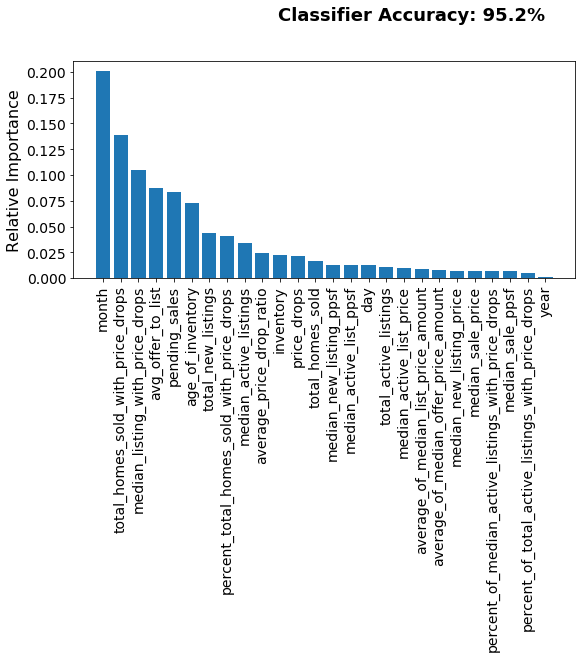

In [21]:
plt.figure(figsize=(9, 4))
plt.bar(np.arange(feature_df.shape[0]), feature_df['Importance'])
plt.xticks(np.arange(feature_df.shape[0]), feature_df['Feature'], fontsize=14, rotation=90)
plt.yticks(fontsize=14)
plt.ylabel("Relative Importance", fontsize=16)
plt.text(25, 0.25, "Classifier Accuracy: {:.1f}%".format(final_accuracy * 100), 
         horizontalalignment='right', fontsize=18, weight='bold')
plt.show()

The classifier identifies the month of the listing as a very predictive feature for whether the listed houses in Seattle will sell quickly or slowly in a given week. We can delve into the `month` values for the two samples to assess the findings.

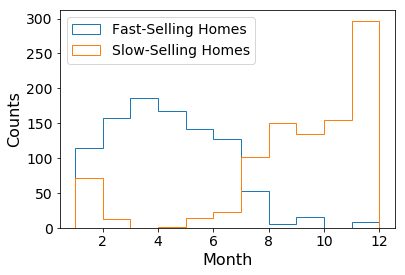

In [22]:
plt.figure()
plt.hist(seattle_fast['month'].values, histtype='step', label='Fast-Selling Homes', bins=11)
plt.hist(seattle_slow['month'].values, histtype='step', label='Slow-Selling Homes', bins=11)
plt.legend(loc='upper left', fontsize=14)
plt.xlabel("Month", fontsize=16)
plt.ylabel("Counts", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

We can conclude that in Seattle, houses listed in the first half of the year are more likely to be sold within 2 weeks of being listed than houses listed during the second half of the year. While a seasonal trend like this is informative, perhaps it overshadows the properties of the housing market itself that also contribute to the rate at which listed houses are sold.

**What if we remove the month? Are there other predictive features worth considering?**


In [23]:
non_month_good_feats = [x for x in good_features if x != 'month']

In [24]:
X = data_df[non_month_good_feats].values
y = data_df['TRUTH'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=6)

rfc = RandomForestClassifier(n_estimators=20, n_jobs=-1, max_depth=9)
rfc.fit(X_train, y_train)
y_test_pred = rfc.predict(X_test)
final_accuracy = accuracy_score(y_test_pred, y_test)

In [25]:
feature_data = [[non_month_good_feats[i], rfc.feature_importances_[i]] for i in range(len(non_month_good_feats))]
feature_df = pd.DataFrame(data=feature_data, columns=['Feature', 'Importance'])
feature_df = feature_df.sort_values(by='Importance', ascending=False)

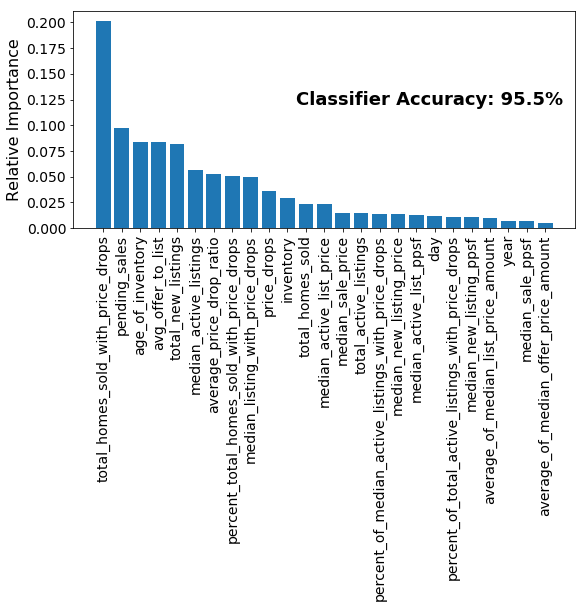

In [26]:
plt.figure(figsize=(9, 4))
plt.bar(np.arange(feature_df.shape[0]), feature_df['Importance'])
plt.xticks(np.arange(feature_df.shape[0]), feature_df['Feature'], fontsize=14, rotation=90)
plt.yticks(fontsize=14)
plt.ylabel("Relative Importance", fontsize=16)
plt.text(25, 0.12, "Classifier Accuracy: {:.1f}%".format(final_accuracy * 100), 
         horizontalalignment='right', fontsize=18, weight='bold')
plt.show()

## Summary

I have developed a predictive method for determining favorable times to sell houses. I analyzed time-series housing-market metrics collected by Redfin. A motivating trend in this dataset is that when more houses sell quickly in an area, the selling point is closer to the initial listing price than in the case where houses do not sell quickly. Using Seattle as a test case, I developed a machine learning approach to identifying the characteristics of the housing market that would label it as a favorable time to sell. The classifer operated with 97% accuracy and eludicated a seasonal trend: homes listed early in the year will be more likely to sell quickly. When this seasonal trend was removed from the dataset, the classifier was able to operate with 96% accuracy and identify favorable times to sell houses primarily based on the number of homes being sold with price drops.